# Determinantal Point Process in Python

First, let's start the environment.

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# Questions

1. How do I define a $L$ kernel? Can it be defined through $B^T B$?
2. The kernel $K$ can be seen as a cumulative function of $L$, since it computes $P_K(A \subseteq \mathbf{Y})$ instead of $P_L(\mathbf{Y} = A)$?

In [4]:
# Understanding broadcasting, used by Kulesza in the MATLAB code (bsxfun)
A = np.arange(0,10) 
print A[np.newaxis].T
print A
print A[np.newaxis].T - A
# You're taking the first elem, say [0], you fill it until it reaches the same rank of A, then you subtract [0] by
# every element in A

# it's like I stacked A[np.newaxis].T until it had 9 dims
print ""
print np.tile(A[np.newaxis].T, (1,10))
print np.tile(A, (10,1)) 
print np.tile(A[np.newaxis].T, (1,10)) - np.tile(A, (10,1))

[[0]
 [1]
 [2]
 [3]
 [4]
 [5]
 [6]
 [7]
 [8]
 [9]]
[0 1 2 3 4 5 6 7 8 9]
[[ 0 -1 -2 -3 -4 -5 -6 -7 -8 -9]
 [ 1  0 -1 -2 -3 -4 -5 -6 -7 -8]
 [ 2  1  0 -1 -2 -3 -4 -5 -6 -7]
 [ 3  2  1  0 -1 -2 -3 -4 -5 -6]
 [ 4  3  2  1  0 -1 -2 -3 -4 -5]
 [ 5  4  3  2  1  0 -1 -2 -3 -4]
 [ 6  5  4  3  2  1  0 -1 -2 -3]
 [ 7  6  5  4  3  2  1  0 -1 -2]
 [ 8  7  6  5  4  3  2  1  0 -1]
 [ 9  8  7  6  5  4  3  2  1  0]]

[[0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 1]
 [2 2 2 2 2 2 2 2 2 2]
 [3 3 3 3 3 3 3 3 3 3]
 [4 4 4 4 4 4 4 4 4 4]
 [5 5 5 5 5 5 5 5 5 5]
 [6 6 6 6 6 6 6 6 6 6]
 [7 7 7 7 7 7 7 7 7 7]
 [8 8 8 8 8 8 8 8 8 8]
 [9 9 9 9 9 9 9 9 9 9]]
[[0 1 2 3 4 5 6 7 8 9]
 [0 1 2 3 4 5 6 7 8 9]
 [0 1 2 3 4 5 6 7 8 9]
 [0 1 2 3 4 5 6 7 8 9]
 [0 1 2 3 4 5 6 7 8 9]
 [0 1 2 3 4 5 6 7 8 9]
 [0 1 2 3 4 5 6 7 8 9]
 [0 1 2 3 4 5 6 7 8 9]
 [0 1 2 3 4 5 6 7 8 9]
 [0 1 2 3 4 5 6 7 8 9]]
[[ 0 -1 -2 -3 -4 -5 -6 -7 -8 -9]
 [ 1  0 -1 -2 -3 -4 -5 -6 -7 -8]
 [ 2  1  0 -1 -2 -3 -4 -5 -6 -7]
 [ 3  2  1  0 -1 -2 -3 -4 -5 -6]
 

In [5]:
n = 10 # thus, N = n^2. As I'm sampling from a plane, D = 2
sigma = 0.1 
grid_points = np.arange(n) / float(n)
xx, yy = np.meshgrid(grid_points, grid_points) # every possibility in the grid

xx = xx.flatten()[np.newaxis].T
yy = yy.flatten()[np.newaxis].T

print "\n(xx - xx.T):\n", (xx - xx.T)
print "\n(xx - xx.T)**2:\n",(xx - xx.T)**2 
print "\n(xx - xx.T)**2 + (yy - yy.T)**2:\n", (xx - xx.T)**2 + (yy - yy.T)**2 
print "\nnp.exp((xx - xx.T)**2 + (yy - yy.T)**2):\n", np.exp((xx - xx.T)**2 + (yy - yy.T)**2)
print "\nnp.exp(-0.5 * ((xx - xx.T)**2 + (yy - yy.T)**2)):\n", np.exp(-0.5 * ((xx - xx.T)**2 + (yy - yy.T)**2))
print "\nnp.exp(-0.5 * ((xx - xx.T)**2 + (yy - yy.T)**2) / sigma**2):\n", np.exp(-0.5 * ((xx - xx.T)**2 + (yy - yy.T)**2) / sigma**2)
L = np.exp(-0.5 * ((xx - xx.T)**2 + (yy - yy.T)**2) / sigma**2)


(xx - xx.T):
[[ 0.  -0.1 -0.2 ..., -0.7 -0.8 -0.9]
 [ 0.1  0.  -0.1 ..., -0.6 -0.7 -0.8]
 [ 0.2  0.1  0.  ..., -0.5 -0.6 -0.7]
 ..., 
 [ 0.7  0.6  0.5 ...,  0.  -0.1 -0.2]
 [ 0.8  0.7  0.6 ...,  0.1  0.  -0.1]
 [ 0.9  0.8  0.7 ...,  0.2  0.1  0. ]]

(xx - xx.T)**2:
[[ 0.    0.01  0.04 ...,  0.49  0.64  0.81]
 [ 0.01  0.    0.01 ...,  0.36  0.49  0.64]
 [ 0.04  0.01  0.   ...,  0.25  0.36  0.49]
 ..., 
 [ 0.49  0.36  0.25 ...,  0.    0.01  0.04]
 [ 0.64  0.49  0.36 ...,  0.01  0.    0.01]
 [ 0.81  0.64  0.49 ...,  0.04  0.01  0.  ]]

(xx - xx.T)**2 + (yy - yy.T)**2:
[[ 0.    0.01  0.04 ...,  1.3   1.45  1.62]
 [ 0.01  0.    0.01 ...,  1.17  1.3   1.45]
 [ 0.04  0.01  0.   ...,  1.06  1.17  1.3 ]
 ..., 
 [ 1.3   1.17  1.06 ...,  0.    0.01  0.04]
 [ 1.45  1.3   1.17 ...,  0.01  0.    0.01]
 [ 1.62  1.45  1.3  ...,  0.04  0.01  0.  ]]

np.exp((xx - xx.T)**2 + (yy - yy.T)**2):
[[ 1.          1.01005017  1.04081077 ...,  3.66929667  4.26311452
   5.05309032]
 [ 1.01005017  1.          1.01

In [6]:
print "the pair (xx[i], yy[i]) contains every possible grid configuration"
print "xx:", xx.shape
print "yy:", yy.shape
print "L:", L.shape

the pair (xx[i], yy[i]) contains every possible grid configuration
xx: (100, 1)
yy: (100, 1)
L: (100, 100)


Mapping indices position to every point in the grid

In [40]:
#idx_to_point = { i: point for i, point in enumerate(zip(xx,yy)) }
#print idx_to_point[0][0][0]

idx_to_point = np.hstack((xx, yy))
point_to_idx = { tuple(point): i for i, point in enumerate(idx_to_point) }

print idx_to_point[[0,5,55,99]]
print idx_to_point[0]

# can't convert floating points to indices
#print point_to_idx[(1,0)]
#print point_to_idx

[[ 0.   0. ]
 [ 0.5  0. ]
 [ 0.5  0.5]
 [ 0.9  0.9]]
[ 0.  0.]


## Computing probabilities using the ensemble kernel $L$

First, computing individual probabilities.

In [8]:
# Computing some probabilities using L-ensembles

# computing the probability of a singleton {i}, i.e., a set containing a single element
# np.linalg.det(L[0,0])
print "Pr(Y = 0) =", L[0,0]
print "Pr(Y = 1) =", L[1,1]

Pr(Y = 0) = 1.0
Pr(Y = 1) = 1.0


Probabilities of more elements.

In [9]:
print "probability of selecting elements (0,0) and (1,0) in the grid"
print L[0:2, 0:2]
print np.linalg.det(L[0:2, 0:2])
print "by hand:", 1*1 - 0.60653066**2
print 
print "probability of selecting elements (0,0),(1,0),(2,0) in the grid"
print L[0:3, 0:3]
print np.linalg.det(L[0:3, 0:3])
print
print "probability of including all points"
print "\n", L
print np.linalg.det(L)

#print "\n", L[3, 3]
#print np.linalg.det(L[0:3, 0:3])


probability of selecting elements (0,0) and (1,0) in the grid
[[ 1.          0.60653066]
 [ 0.60653066  1.        ]]
0.632120558829
by hand: 0.63212055848

probability of selecting elements (0,0),(1,0),(2,0) in the grid
[[ 1.          0.60653066  0.13533528]
 [ 0.60653066  1.          0.60653066]
 [ 0.13533528  0.60653066  1.        ]]
0.345499615504

probability of including all points

[[  1.00000000e+00   6.06530660e-01   1.35335283e-01 ...,   5.90009054e-29
    3.26324786e-32   6.63967720e-36]
 [  6.06530660e-01   1.00000000e+00   6.06530660e-01 ...,   3.92439586e-26
    5.90009054e-29   3.26324786e-32]
 [  1.35335283e-01   6.06530660e-01   1.00000000e+00 ...,   9.60268005e-24
    3.92439586e-26   5.90009054e-29]
 ..., 
 [  5.90009054e-29   3.92439586e-26   9.60268005e-24 ...,   1.00000000e+00
    6.06530660e-01   1.35335283e-01]
 [  3.26324786e-32   5.90009054e-29   3.92439586e-26 ...,   6.06530660e-01
    1.00000000e+00   6.06530660e-01]
 [  6.63967720e-36   3.26324786e-32   5.90

In [10]:
# taking all but one column trick
A = np.array([[1,2,3,1],[4,5,6,2],[7,8,9,3],[0,0,0,4]])
print A
A[ [[0],[2],[3]] , [0,2,3] ]

[[1 2 3 1]
 [4 5 6 2]
 [7 8 9 3]
 [0 0 0 4]]


array([[1, 3, 1],
       [7, 9, 3],
       [0, 0, 4]])

In [11]:
print "i = {0,1,2}:", 
#print L[ [[0],[1],[2]] , [0,1,2] ]
print np.linalg.det(L[ [[0],[1],[2]] , [0,1,2] ])

print "i = {0,1,3}:", 
#print L[ [[0],[1],[3]] , [0,1,3] ]
print np.linalg.det(L[ [[0],[1],[3]] , [0,1,3] ])

print "i = {0,1,4}:", 
#print L[ [[0],[1],[4]] , [0,1,4] ]
print np.linalg.det(L[ [[0],[1],[4]] , [0,1,4] ])

print "i = {0,1,9}:", 
#print L[ [[0],[1],[9]] , [0,1,9] ]
print np.linalg.det(L[ [[0],[1],[9]] , [0,1,9] ])

print "\nAs expected, the set {0,1,2} has lower probability than other sets with more distant numbers,",
print "such as {0,1,3}, {0,1,9}"

i = {0,1,2}: 0.345499615504
i = {0,1,3}: 0.615505274067
i = {0,1,4}: 0.632001557148
i = {0,1,9}: 0.632120558829

As expected, the set {0,1,2} has lower probability than other sets with more distant numbers, such as {0,1,3}, {0,1,9}


In [12]:
# coding a way to use only the elements that i'm interested
A = np.array([[1,2,3,1],[4,5,6,2],[7,8,9,3],[0,0,0,4]])
selected_items = [0,3]
#br_idxs = map(lambda x: list(x), selected_items) # broadcasted items
br_idxs = [[a] for a in selected_items]

print br_idxs
print A[br_idxs, selected_items]

[[0], [3]]
[[1 1]
 [0 4]]


## Computing kernel $K$ from ensemble $L$

There are two ways to compute the marginal kernel $K$. Using the following operation:

$K = L (L+I)^{-1}$.

Or using the eigendecomposition of $L$:

$K = \sum_{n=1}^N{( \frac{\lambda_n}{\lambda_n + 1} \mathbf{v_n} \mathbf{v_n}^T )}$.

In [13]:
import scipy.linalg

# Using the first form:
K = L.dot( L + np.eye(L.shape[0], L.shape[1]) )
print "K =", K


# or using eigendecomposition:
#eV, eD = scipy.linalg.eig(L)
#
# (eV / (eV + 1.0))
#Lrecomp = np.zeros_like(eD)
#for i in xrange(eD.shape[0]):
#    print (eV[i]/(eV[i] + 1))
#    print (eD[i].dot(eD[i].T))
#    Lrecomp[i,:] = (eV[i]/(eV[i] + 1)) * eD[i].dot(eD[i].T)



K = [[  2.92187927e+00   2.40410551e+00   1.02997297e+00 ...,   2.41262239e-14
    5.67511804e-16   8.09344647e-18]
 [  2.40410551e+00   3.43187738e+00   2.51790147e+00 ...,   6.22352262e-13
    2.41262239e-14   5.67511804e-16]
 [  1.02997297e+00   2.51790147e+00   3.45726869e+00 ...,   9.73321340e-12
    6.22352262e-13   2.41262239e-14]
 ..., 
 [  2.41262239e-14   6.22352262e-13   9.73321340e-12 ...,   3.45726869e+00
    2.51790147e+00   1.02997297e+00]
 [  5.67511804e-16   2.41262239e-14   6.22352262e-13 ...,   2.51790147e+00
    3.43187738e+00   2.40410551e+00]
 [  8.09344647e-18   5.67511804e-16   2.41262239e-14 ...,   1.02997297e+00
    2.40410551e+00   2.92187927e+00]]


In [14]:
# computing the same previous probabilities, but using the marginal kernel K
def rev_idxs(items):
    idxs_list = [[a] for a in items]
    return idxs_list, items

print "i = {0,1,2}:",
print np.linalg.det(K[ rev_idxs([0,1,2]) ])

print "i = {0,1,3}:",
print np.linalg.det(K[ rev_idxs([0,1,3]) ])

print "i = {0,1,4}:",
print np.linalg.det(K[ rev_idxs([0,1,4]) ])

print "i = {0,1,9}:",
print np.linalg.det(K[ rev_idxs([0,1,9]) ])

i = {0,1,2}: 4.99038723497
i = {0,1,3}: 12.6287989816
i = {0,1,4}: 14.5252532566
i = {0,1,9}: 12.4115823498


As ensemble $L$, notice that $K$ is not necessarily normalized, as it is also a state of proportionality. Also, $K$ computes a different probability of $L$. $K$ comprises the marginal probabilities of inclusion for subsets $A$, while $L$ specifies atomic probabilities for every possible instantiation of $\mathbf{Y}$.

## Dummy sampling algorithm

A dummy sampling approach consists of sampling an element a subset/element $A = {i}$ with probability $P(A = \{i\})$. After sampling the first element, we recompute the probabilities, but conditioning on the value that was previously sampled. Kulesza et al. presents a better approach based on the eigendecomposition, that we shall see further ahead.

In this sampling problem, we shall consider the same example of sampling a set of points $\{1,2,\dots,n\}$ from a 2D grid. Reintroducing the data:

In [74]:
n = 10 # thus, N = n^2. As I'm sampling from a plane, D = 2
sigma = 0.1 
grid_points = np.arange(n) / float(n)

Defining functions to compute probabilities:

In [76]:
from dpp import DPP
            
dpp_grid = DPP(grid_points)

print "sanity check"
print "i = {0,1,2}:", dpp_grid.prob([0,1,2])
print "i = {1,2,3}:", dpp_grid.prob([1,2,3])
print 
print "sampling distance points in the grid:"
print "i = {0,50,99}:", dpp_grid.prob([0,50,99]) # selecting distant points in the diagonal
print "i = {0,33,77}:", dpp_grid.prob([0,33,77])
print "i = {0,10,20}:", dpp_grid.prob([0,10,20])
print "i = {0,5,10}:", dpp_grid.prob([0,5,10])
print
print "conditional probabilities"
print "i = {0,1,2}:", dpp_grid.prob([0,1,2])
print "B = {3} | A = {0,1,2}:", dpp_grid.cond_prob([3], [0,1,2])
print "B = {4} | A = {0,1,2}:", dpp_grid.cond_prob([4], [0,1,2])
print "B = {9} | A = {0,1,2}:", dpp_grid.cond_prob([9], [0,1,2])
print 
print "B = {2} | A = {0,1}:", dpp_grid.cond_prob([2], [0,1])
print "B = {3} | A = {0,1}:", dpp_grid.cond_prob([3], [0,1])
print "B = {99} | A = {0,50}:", dpp_grid.cond_prob([99], [0,50])

sanity check
i = {0,1,2}: 0.345499615504
i = {1,2,3}: 0.345499615504

sampling distance points in the grid:
i = {0,50,99}: 0.999999999986
i = {0,33,77}: 0.99999998477
i = {0,10,20}: 0.345499615504
i = {0,5,10}: 0.63212055882

conditional probabilities
i = {0,1,2}: 0.345499615504
B = {3} | A = {0,1,2}: 3.14657952782e+44
B = {4} | A = {0,1,2}: 5.88077261179e+44
B = {9} | A = {0,1,2}: 6.0585699045e+44

B = {2} | A = {0,1}: 1.14564728473e+44
B = {3} | A = {0,1}: 2.04096304113e+44
B = {99} | A = {0,50}: 7.08930816958e+43


In [77]:
sampled_idxs = dpp_grid.dummy_sampling(20, verbose=True)
print sampled_idxs

Iteration: 0
Y [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]
p [ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
  0.01  0.01

Scatter plot of the sampled points

[[ 0.5  0.4]
 [ 0.9  0.5]
 [ 0.4  0.6]
 [ 0.   0.3]
 [ 0.8  0.7]
 [ 0.2  0.7]
 [ 0.   0.7]
 [ 0.8  0.4]
 [ 0.3  0.8]
 [ 0.5  0.8]
 [ 0.1  0.4]
 [ 0.3  0.4]
 [ 0.2  0.2]
 [ 0.6  0.2]
 [ 0.1  0.6]
 [ 0.   0.8]
 [ 0.3  0.5]
 [ 0.8  0. ]
 [ 0.5  0.7]
 [ 0.   0.2]]


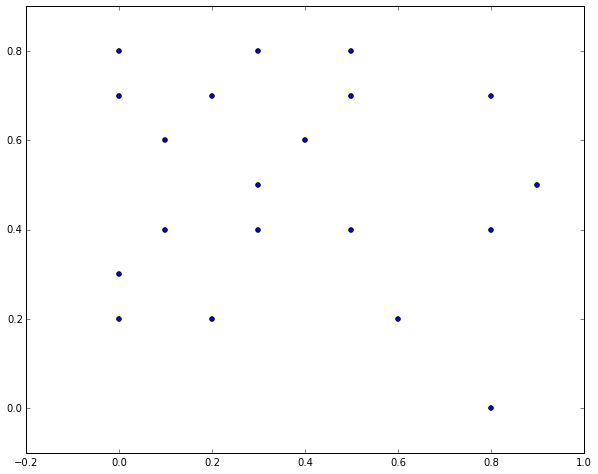

In [84]:
# now, convert the points and do a scatter plot
"""
n = 10 # thus, N = n^2. As I'm sampling from a plane, D = 2
sigma = 0.1 
grid_points = np.arange(n) / float(n)
dpp_grid = DPP(grid_points)
"""
sampled_idxs = dpp_grid.dummy_sampling(20)
sampled_points = dpp_grid.idx_to_point[sampled_idxs]
print sampled_points
plt.scatter(sampled_points[:,0], sampled_points[:,1])

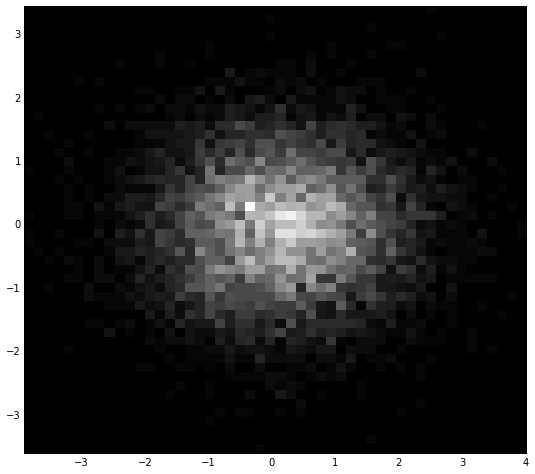

In [19]:
# Generate some test data
x = np.random.randn(8873)
y = np.random.randn(8873)

heatmap, xedges, yedges = np.histogram2d(x, y, bins=50)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.clf()
plt.imshow(heatmap, extent=extent)
plt.show()